In [35]:
# Standard imports
from __future__ import annotations
from pathlib import Path

# Tensorflow and numpy imports
import tensorflow as tf
import numpy as np

# Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib import ticker, cm 
from matplotlib.colors import LinearSegmentedColormap

In [36]:
# Selecting the region
REGION_1 = lambda x: 0.5*(x[:,1]-0.5)**2 - 0.4*(x[:,0]-0.5)**2 < 0.02
REGION_2 = lambda x: 0.5*(x[:,1]-0.5)**2 + (x[:,0]-0.5)**2 < 0.2

# Selecting primary colors
PRIMARY_COLOR_POSITIVE = 'mediumspringgreen'
PRIMARY_COLOR_NEGATIVE = 'violet'
CMAP = LinearSegmentedColormap.from_list("Custom", [PRIMARY_COLOR_NEGATIVE, PRIMARY_COLOR_POSITIVE], N=20)

# Picking a number of points to draw
DATASET_SIZE = 1000
RADIUS = 0.8

def get_labels(x: np.ndarray) -> np.ndarray:
    """
    Based on array of R^2 coordinates, returns an array of bits indicating
    whether the point is included in the region
    """
    
    return REGION_1(x)

def generate_dataset() -> np.ndarray:
    """
    Generates a random dataset based on the curve provided
    """
    
    x = tf.random.uniform(shape=(DATASET_SIZE, 2))
    return x, get_labels(x)

def display_dataset(x: np.ndarray, y: np.ndarray, save_path: Path = None) -> None:
    """
    Displays the dataset in a form of a scatterplot
    
    Args:
        x - an array of points in R^2
        y - an array of bits, marking the class of each point
    """
    
    # Split the dataset into two parts
    x_positive = np.array([x for x, y in zip(x, y) if y])
    x_negative = np.array([x for x, y in zip(x, y) if not y])
    
    assert len(x_positive) > 0, "There are no positive labels! Try something else..."
    assert len(x_negative) > 0, "There are no negative labels! Try something else..."
    
    # Display two scatterplots
    fig, ax = plt.subplots()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.scatter(x_positive[:,0], x_positive[:,1], color=PRIMARY_COLOR_POSITIVE, edgecolors='black')
    plt.scatter(x_negative[:,0], x_negative[:,1], color=PRIMARY_COLOR_NEGATIVE, edgecolors='black')
    plt.grid()
    
    # Showing the plot and saving if needed
    if save_path is not None:
        plt.savefig(save_path, transparent=True)
    
    plt.show()

def display_dataset_with_heatmap(x: np.ndarray, 
                                 y: np.ndarray, 
                                 fn: callable, 
                                 save_path: Path = None) -> None:
    """
    Displays the dataset in a form of a scatterplot together
    with the heatmap plotted using fn function
    
    Args:
        x - an array of points in R^2
        y - an array of bits, marking the class of each point
        fn - function from R^2 to R, according to which the heatmap is built
        save_path - path where image is saved. Select None to omit saving
    """
    
    # Preparing the plot
    fig, ax = plt.subplots()

    # Show the heatmap
    x_nodes = np.linspace(0.0, 1.0, 3000)
    y_nodes = np.linspace(0.0, 1.0, 3000)
    xx, yy = np.meshgrid(x_nodes, y_nodes)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))
    prediction = np.array(fn(grid))
    zz = prediction.reshape(xx.shape)
    c = plt.contourf(xx, yy, zz, cmap=CMAP)
    fig.colorbar(c)

    # Split the dataset into two parts
    x_positive = np.array([x for x, y in zip(x, y) if y])
    x_negative = np.array([x for x, y in zip(x, y) if not y])
    
    # Display two scatterplots
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.scatter(x_positive[:,0], x_positive[:,1], color=PRIMARY_COLOR_POSITIVE, edgecolors='black')
    plt.scatter(x_negative[:,0], x_negative[:,1], color=PRIMARY_COLOR_NEGATIVE, edgecolors='black')
    plt.grid()
    
    # Showing the plot and saving if needed
    if save_path is not None:
        plt.savefig(save_path, transparent=True)
    
    plt.show()

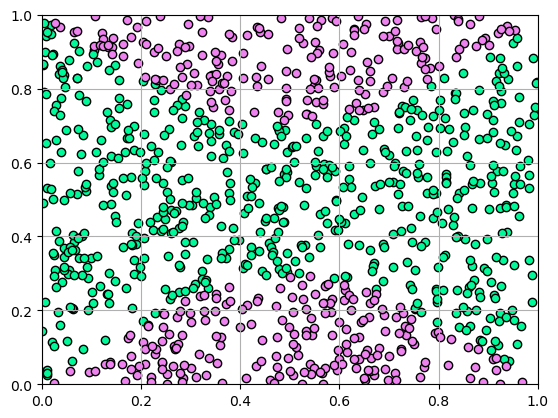

In [37]:
x, y = generate_dataset()
display_dataset(x, y, save_path='dataset.pdf')

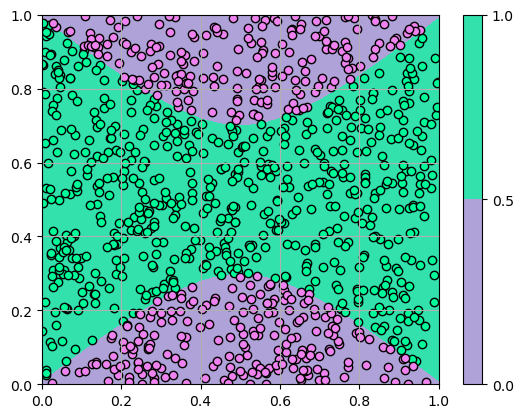

In [38]:
display_dataset_with_heatmap(x, y, get_labels, save_path='./classification-example.pdf')

In [39]:
# Convert array of bits to array of 0.0's and 1.0's
y = tf.cast(y, tf.float32)

In [40]:
class CybenkoNetwork:
    """
    Class representing the Cybenko network
    """
    
    ACTIVATION = 'sigmoid'
    INITIALIZER = 'GlorotNormal'
    LEARNING_RATE = 0.05
    
    def __init__(self, hidden_layer_size: int = 6, learning_rate: float = 0.05) -> None:
        """
        Initializes the CybenkoNetwork instance.
        
        Args:
            - hidden_layer_size: number of hidden neurons (n from paper)
            - learning_rate: how fast to train the network
        """
        
        self._hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, 
                                             activation=CybenkoNetwork.ACTIVATION, 
                                             bias_initializer=CybenkoNetwork.INITIALIZER,
                                             kernel_initializer=CybenkoNetwork.INITIALIZER)
        self._alpha = tf.Variable(tf.random.normal((1, hidden_layer_size)), name='alpha')
        self._optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        self._mean = 0.5 # Value needed for final classification
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Based on the batch of inputs, gives a batch of predictions
        
        Args:
            x - batch of inputs
        """
        
        z = self._hidden_layer(x)
        return tf.matmul(self._alpha, tf.transpose(z))
    
    def predict_binary(self, x: np.ndarray) -> np.ndarray:
        """
        Predicts the class of each x value in a form of bit
        
        Args:
            x - batch of inputs
        """
        
        prediction = self.predict(x)
        return prediction > self._mean
    
    def train(self, x: np.ndarray, y: np.ndarray, epochs: int = 5000, batch_size: int = 1024) -> None:
        """
        Trains the model on given dataset (x, y) with the specified number of epochs 
        and batch size.
        
        Args:
            x, y - array of R^2 coordinates and corresponding label
            epochs - number of epochs to train with
            batch_size - number of pairs for each gradient iteration step
        """
        
        for epoch in range(epochs):
            for offset in range(0, len(x), batch_size):
                # Getting the batch
                xs, ys = x[offset: offset + batch_size], y[offset: offset + batch_size]

                with tf.GradientTape() as tape:
                    # Forward pass: calculating the MSE loss
                    loss_value = tf.reduce_mean((self.predict(xs) - np.array([ys]))**2)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, [self._alpha, *self._hidden_layer.trainable_variables])
                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                self._optimizer.apply_gradients(zip(grads, [self._alpha, *self._hidden_layer.trainable_variables]))
            
            if (epoch + 1) % 100 == 0:
                print(f'Finished epoch {epoch+1}, loss value: {loss_value}...')
        
        print('Training finished!')
        # Calculating the mean score for the whole dataset 
        # (needed further to predict the class in the binary form)
        self._mean = np.mean(self.predict(x))

In [41]:
# Initializing and training the model
HIDDEN_LAYER_SIZE = 6

model = CybenkoNetwork(hidden_layer_size=HIDDEN_LAYER_SIZE, learning_rate=0.05)
model.train(x, y, epochs=5000, batch_size=1024)

Finished epoch 100, loss value: 0.23830066621303558...
Finished epoch 200, loss value: 0.23457413911819458...
Finished epoch 300, loss value: 0.21761175990104675...
Finished epoch 400, loss value: 0.16533619165420532...
Finished epoch 500, loss value: 0.12053705751895905...
Finished epoch 600, loss value: 0.1017402708530426...
Finished epoch 700, loss value: 0.08269840478897095...
Finished epoch 800, loss value: 0.07698618620634079...
Finished epoch 900, loss value: 0.07625303417444229...
Finished epoch 1000, loss value: 0.07577396184206009...
Finished epoch 1100, loss value: 0.07527292519807816...
Finished epoch 1200, loss value: 0.0746772438287735...
Finished epoch 1300, loss value: 0.07391871511936188...
Finished epoch 1400, loss value: 0.07296380400657654...
Finished epoch 1500, loss value: 0.07189083844423294...
Finished epoch 1600, loss value: 0.07089082151651382...
Finished epoch 1700, loss value: 0.07012363523244858...
Finished epoch 1800, loss value: 0.06961224973201752...
Fin

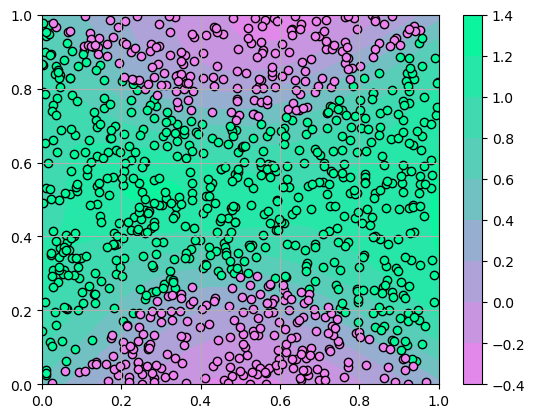

In [42]:
display_dataset_with_heatmap(x, y, model.predict, save_path='classification-cont-prediction.pdf')

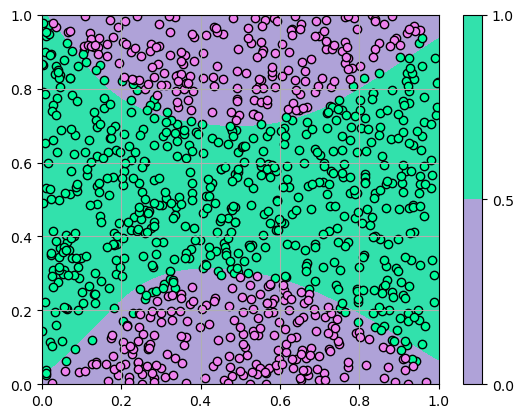

0.60161144


In [43]:
display_dataset_with_heatmap(x, y, model.predict_binary, save_path='classification-discr-prediction.pdf')
print(model._mean)

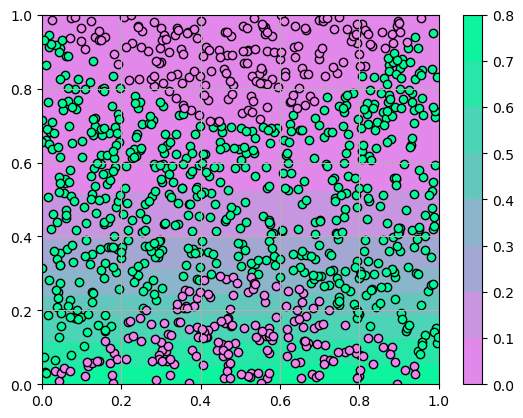

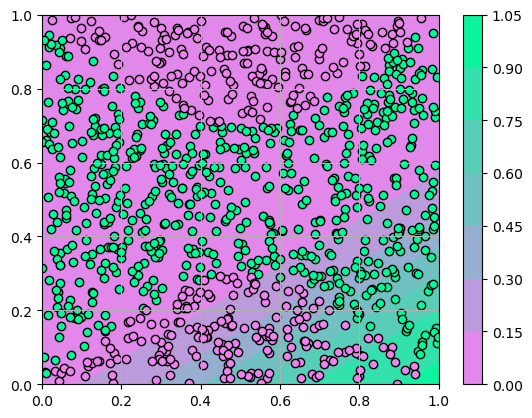

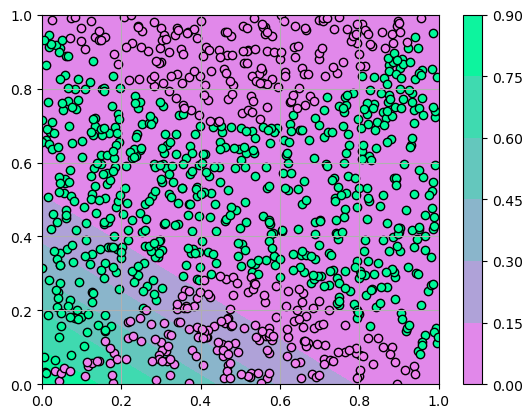

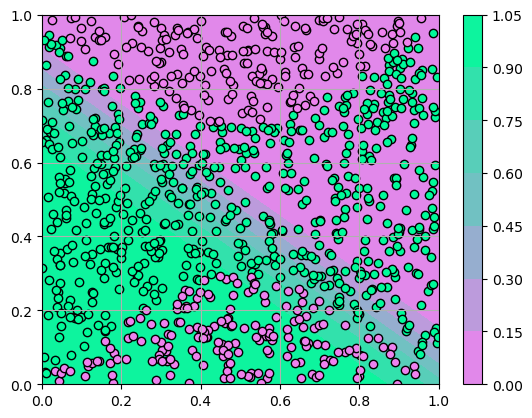

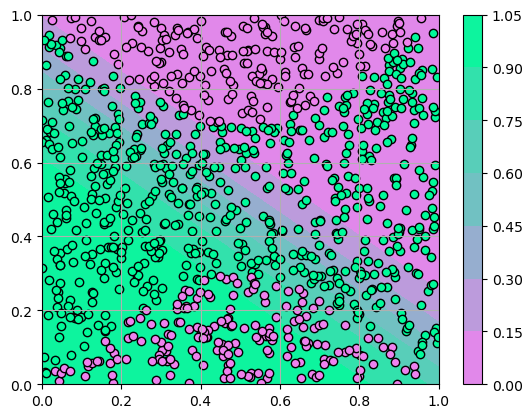

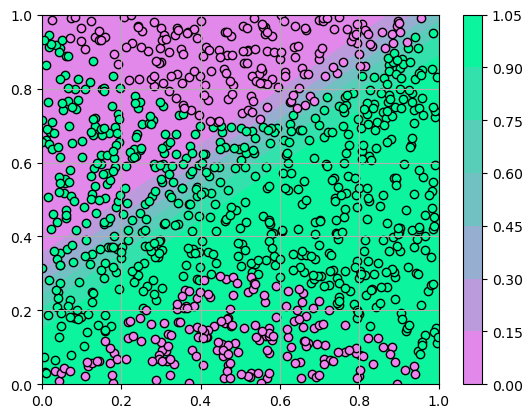

In [102]:
for i in range(HIDDEN_LAYER_SIZE):
    display_dataset_with_heatmap(x, y, 
                                 lambda x: np.array([model._hidden_layer(x)[:,i]]), 
                                 save_path=f'layer-{i+1}-prediction.pdf')

In [104]:
print('Weights and biases:', model._hidden_layer.trainable_variables)
print('alpha weights:', model._alpha)

Weights and biases: [<tf.Variable 'dense_10/kernel:0' shape=(2, 6) dtype=float32, numpy=
array([[  0.05871968,   4.8505516 ,  -4.390814  , -11.811486  ,
         -7.5851793 ,  14.192825  ],
       [ -6.4417024 ,  -7.66661   ,  -6.7588954 , -15.6663475 ,
        -10.264523  , -19.17103   ]], dtype=float32)>, <tf.Variable 'dense_10/bias:0' shape=(6,) dtype=float32, numpy=
array([ 1.1290237, -2.1969671,  1.7187642, 12.474184 ,  8.461851 ,
        5.023767 ], dtype=float32)>]
alpha weights: <tf.Variable 'alpha:0' shape=(1, 6) dtype=float32, numpy=
array([[-8.179248 ,  3.8051255,  3.9156759, -3.4121804,  5.066652 ,
         1.1616282]], dtype=float32)>
